In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from chnet.torchsummary import summary
from torchvision import transforms, utils
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [3]:
import chnet.utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools
from chnet.ch_loader import CahnHillDataset

In [4]:
warnings.filterwarnings('ignore')

## Loss Functions

In [17]:
@curry
def rmse_loss(y1, y2):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()).item()

## Data Generators

In [6]:
@curry
def init_norm(nsamples, dim_x, dim_y, seed=354875, m_l=-0.15, m_r=0.15):
    np.random.seed(seed)
    means  = np.random.uniform(m_l, m_r, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.05, 0.3, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.98, 0.98, out=x_data)
    
    return x_data

@curry
def data_generator_slices(nsamples=2, 
                   dim_x=64, 
                   init_steps=1, 
                   delta_sim_steps = 100,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   n_step = 4,
                   m_l=-0.15, 
                   m_r=0.15,
                   device = torch.device("cuda:0")):
    
    init_data = init_norm(nsamples, dim_x, dim_x, seed=seed, m_l=m_l, m_r=m_r)   

    x_list = []
    y_list = []
    
    x_data = ch.ch_run_torch(init_data, 
                             dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, 
                             device=device)    
    

    for _ in range(n_step):
        x_list.append(x_data[None])
        x_data = ch.ch_run_torch(x_data, 
                                 dt=dt, gamma=gamma, 
                                 dx=dx, sim_step=delta_sim_steps, 
                                 device=device)
        y_list.append(x_data[None])
    
    x_data = np.moveaxis(np.concatenate(x_list, axis=0), 0, 1)
    y_data = np.moveaxis(np.concatenate(y_list, axis=0), 0, 1)
    
    return x_data, y_data

# Set Device

In [7]:
device = torch.device('cuda')
# device = torch.device("cpu")

In [41]:
n_step = 5
nsamples=8
x_val, y_val = data_generator_slices(nsamples=nsamples, 
                                    dim_x=96, 
                                    init_steps=1, 
                                    delta_sim_steps=400,
                                    dx=0.25, 
                                    dt=0.01,
                                    gamma=1.0, 
                                    seed=174753,
                                    n_step=n_step,
                                    device=device)



val_dataset = CahnHillDataset(x_val, y_val, transform_x=lambda x: x[:,None], transform_y=lambda x: x[:,None])
val_loader = DataLoader(val_dataset, batch_size=nsamples, shuffle=True, num_workers=1)

item_prd = next(iter(val_loader))

In [46]:
model_name = "out/unet_convLSTM_ch32_step_400_nstep_5_4thtry.pt"
# model_name = "out/unet_convLSTM_ch32_step_400_nstep_5_swapped.pt"

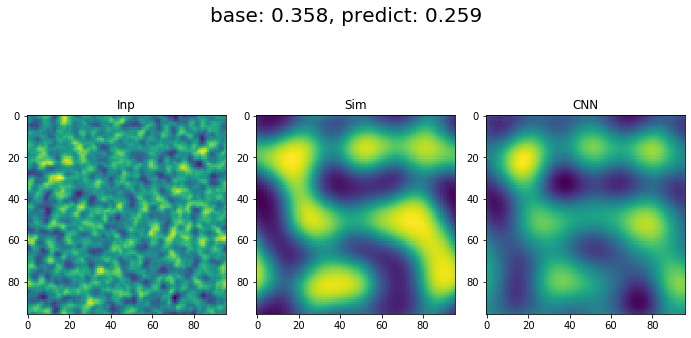

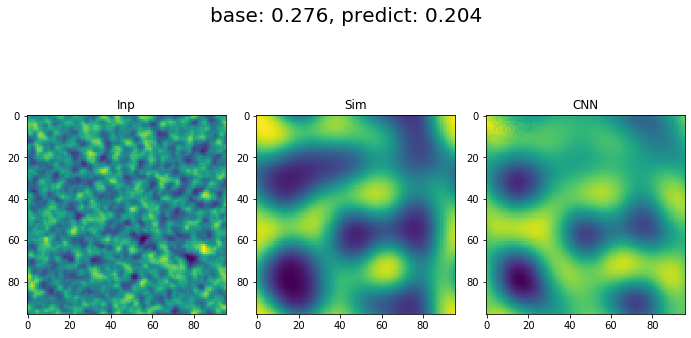

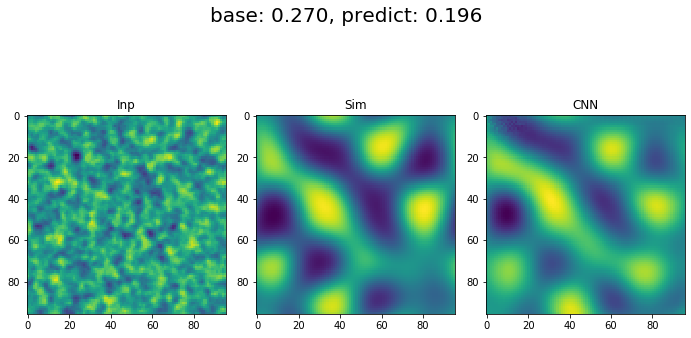

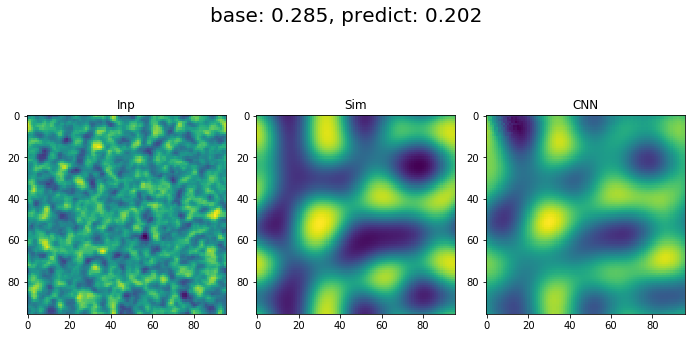

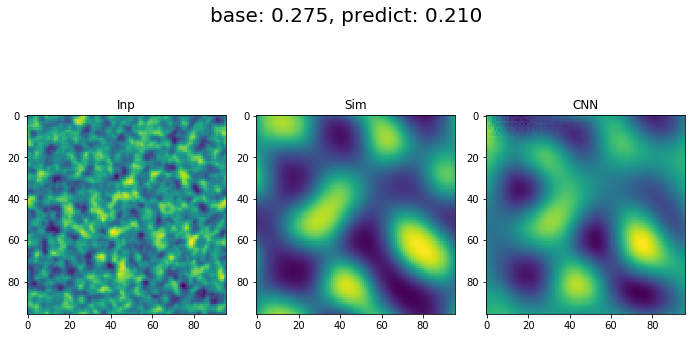

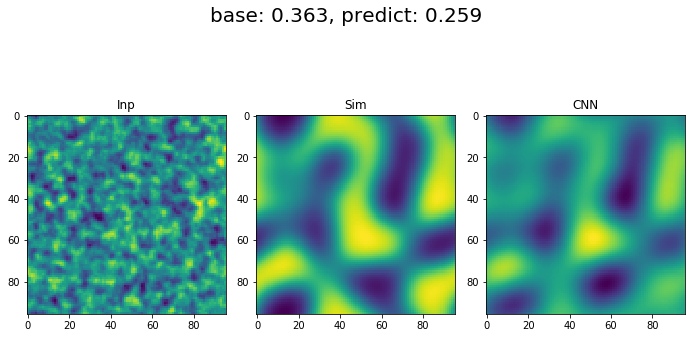

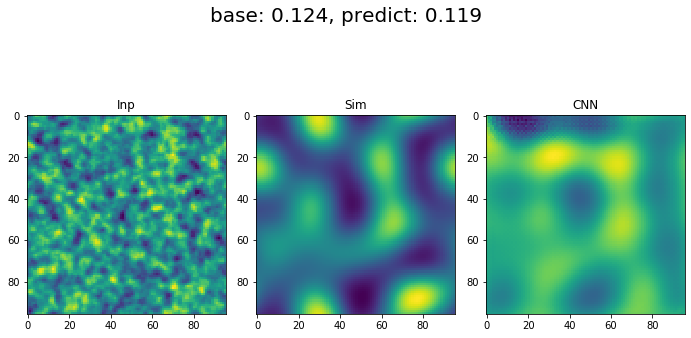

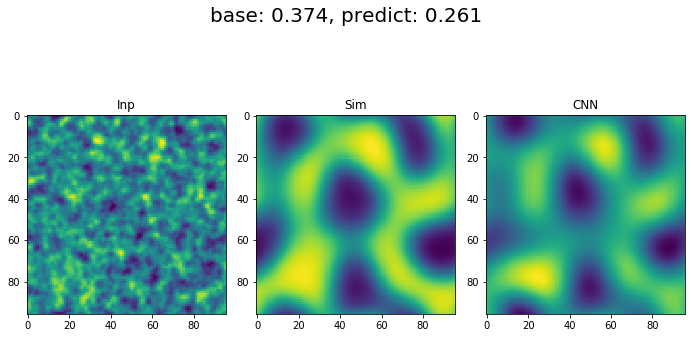

In [47]:
from chnet.lstm_unet import LSTM_Unet

model = LSTM_Unet(input_nc=1, output_nc=1, ngf=32, temporal=n_step).double().to(device)
model.load_state_dict(torch.load(model_name, map_location=device))

model.eval()

x1 = item_prd['x'].to(device)
y1 = item_prd['y'].to(device)
y2, y2_u = model.predict(x1[:,0])

for ix in range(nsamples):
    im_x1 = x1[ix, 0, 0].detach().cpu().numpy()
    im_y1 = y1[ix, -1, 0].detach().cpu().numpy()
    im_y2 = y2[ix, -1, 0].detach().cpu().numpy()
    err0  = error(im_x1, im_y1)
    err1  = error(im_y1, im_y2)
    utils.draw_by_side([im_x1, im_y1, im_y2], 
                       title="base: {:1.3f}, predict: {:1.3f}".format(err0, err1), 
                       sub_titles=["Inp", "Sim", "CNN"])

In [30]:
error = lambda x,y: np.mean(np.fabs(x-y))



In [24]:
for n in range(n_step):
    e1 = rmse_loss(y2[0, n, 0], y1[0, n, 0])
    e2 = rmse_loss(x1[0, 0, 0], y1[0, n, 0])
    print(n, "pred err: {:1.4f}".format(e1), "base err: {:1.4f}".format(e2), "ratio: {:.3f}".format(e1/e2))

0 pred err: 0.0144 base err: 0.0297 ratio: 0.486
1 pred err: 0.0131 base err: 0.0420 ratio: 0.312
2 pred err: 0.0249 base err: 0.0863 ratio: 0.289
3 pred err: 0.0490 base err: 0.1888 ratio: 0.260
4 pred err: 0.0662 base err: 0.3347 ratio: 0.198


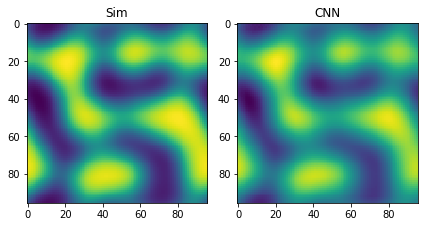

In [73]:
model.eval()
im = model.uout(model.unet(x1[:,-1])).detach()
utils.draw_by_side(y1[0,-1,0], im[0,0], title_left="Sim", title_right="CNN")

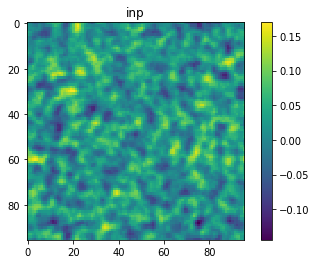

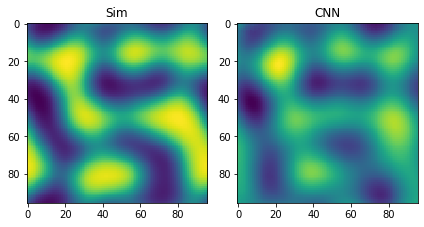

baseline: 0.372, predict: 0.277


In [50]:
x1 = item_prd['x'].to(device)
y1 = item_prd['y'].to(device)
y2, y2_u = model.predict(x1[:,0])

ix = 0
im_x1 = x1[ix].detach().cpu().numpy()
im_y1 = y1[ix].detach().cpu().numpy()
im_y2 = y2[ix].detach().cpu().numpy()

utils.draw_im(im_x1[0][0], "inp")

i = -1
utils.draw_by_side(im_y1[i][0], im_y2[i][0], title_left="Sim", title_right="CNN")


print("baseline: {:1.3f}, predict: {:1.3f}".format(rmse_loss(y1[:,i], x1[:,0]).data, 
                                               rmse_loss(y1[:,i], y2_u[:,i]).data))

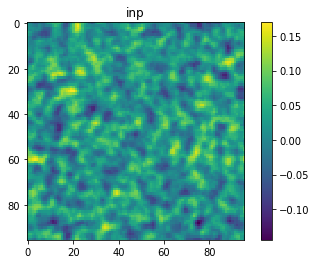

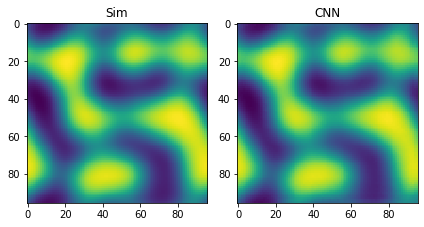

baseline: 0.372, predict: 0.023


In [13]:
from chnet.lstm_unet import Unet_solo
unet = Unet_solo(input_nc=1, 
                  output_nc=1, 
                  ngf=32, 
                  k=1, 
                  tanh=True).double().to(device)

unet.load_state_dict(torch.load("out/unet_model_ch32_1_2000_longrun.pt", map_location=device))
unet.eval()

y2 = unet(x1[:,0])

ix = -1
im_x1 = x1[ix][0].detach().cpu().numpy()
im_y1 = y1[ix][-1].detach().cpu().numpy()
im_y2 = y2[ix].detach().cpu().numpy()

utils.draw_im(im_x1, "inp")

utils.draw_by_side(im_y1, im_y2, title_left="Sim", title_right="CNN")

print("baseline: {:1.3f}, predict: {:1.3f}".format(rmse_loss(y1[:,-1], x1[:,0]).data, rmse_loss(y1[:,-1], y2).data))